# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric import seed_everything

import sys
sys.path.append("../../..")
from src.models import training_utils, base_model

seed = 4
seed_everything(seed)

data_folder = f"../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/"
save_to = reports_folder+"model_selection/random_walk_analysis/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
walk_results = pd.read_csv(reports_folder+"random_walks/walk_2/random_walk_results.csv",index_col=0)
# walk_results.feature_type = walk_results.feature_type.apply(lambda x: "lsa_scaled" if x == "lsa" else x)
walk_results.layer_connectivity = walk_results.layer_connectivity.replace([np.nan], [None])

walk_results.sort_values(by="mean_auc",ascending=False)[:5]

,hidden_channels,micro_aggregation,macro_aggregation,layer_connectivity,L2_norm,pre_process_layers,msg_passing_layers,post_process_layers,normalize_output,jumping_knowledge,...,dropout,weight_decay,lr,epochs,patience,delta,sample_epochs,supervision_types,mean_auc,std
2,64,mean,mean,skipsum,False,0,3,2,False,True,...,0.1,0.001,0.001,400,10,0.1,10,"[('gene_protein', 'gda', 'disease')]",0.8864,0.003007
49,64,max,mean,skipsum,True,0,4,2,False,True,...,0.1,0.001,0.001,400,10,0.1,10,"[('gene_protein', 'gda', 'disease')]",0.8840,0.003742
20,64,sum,sum,None,True,0,4,2,False,True,...,0.1,0.001,0.001,400,10,0.1,10,"[('gene_protein', 'gda', 'disease')]",0.8822,0.005706
19,64,sum,max,None,True,0,4,2,False,True,...,0.1,0.001,0.001,400,10,0.1,10,"[('gene_protein', 'gda', 'disease')]",0.8816,0.003980
1,64,mean,mean,None,False,0,3,2,False,True,...,0.1,0.001,0.001,400,10,0.1,10,"[('gene_protein', 'gda', 'disease')]",0.8812,0.003250


In [3]:
seeds = [4,5,6,7,8]
data = []
for seed in seeds:
    datasets, node_map = training_utils.load_data(data_folder+f"seed_{seed}/")
    data.append(datasets)

full_set = torch.load(data_folder+f"seed_{seeds[-1]}/full_dataset.pt")

In [4]:
def run_experiment(params, train_set, val_set,negative_sampler):
    # Initialize node features
    if params["feature_type"] not in ["lsa","lsa_norm","lsa_scaled"]:
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], feature_folder
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], feature_folder
        )

    train_set.to(device)
    val_set.to(device)

    # Initialize model
    model = base_model.base_model(
        params, train_set.metadata(), params["supervision_types"]
    )
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = training_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in range(epochs):
        #Resample negative supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            # sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            # positive_sample = train_label_index[:,sample_index]

            # positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index.to(device)
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label.to(device)

        train_loss = training_utils.train(model, optimizer, train_set)
        val_loss = training_utils.get_val_loss(model, val_set)

        train_score = training_utils.test(model, train_set)
        val_score = training_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = training_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

def run_multiple_seeds(datasets,experiment_params,negative_sampler):
    experiment_metrics = []
    models = []
    curves = []
    for seed_dataset in datasets:
        train_data, val_data = seed_dataset
        seed_auc, trained_model, training_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
        experiment_metrics.append(seed_auc)
        models.append(trained_model)
        curves.append(training_curve)
    
    metrics = (np.mean(experiment_metrics),np.std(experiment_metrics))
    
    return [metrics, models, curves]

In [5]:
def plot_training_stats_sep(title, train_losses,val_losses, train_metric,val_metric,figsave_dir=None):

  fig, ax = plt.subplots(nrows=2,ncols=1,figsize = (7,6))
  ax1, ax2 = ax
  ax2.set_xlabel("Training Epochs")
  ax1.set_ylabel("AUROC")
  ax2.set_ylabel("Loss")
  ax1.grid()
  ax2.grid()

  p1, = ax1.plot(train_metric, "b-", label="Train AUROC")
  p2, = ax1.plot(val_metric, "r-", label=f"Validation AUROC")
  p3, = ax2.plot(train_losses, "b-", label=f"Train loss")
  p4, = ax2.plot(val_losses,"r-",label=f"Validation loss")
  ax1.legend(handles=[p1,p2],loc=2)
  ax2.legend(handles=[p3,p4],loc=2)
  fig.suptitle(title)
  fig.tight_layout()
  plt.show()

  if figsave_dir is not None:
    fig.savefig(figsave_dir)

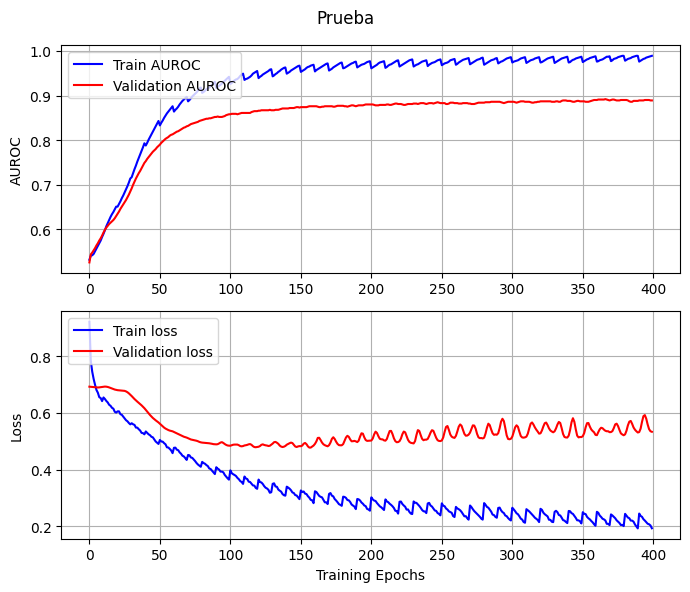

In [62]:
plot_training_stats_sep("Prueba",*curves[0])

Early stopping
Early stopping
Early stopping
(0.8850000000000001, 0.003162277660168382)


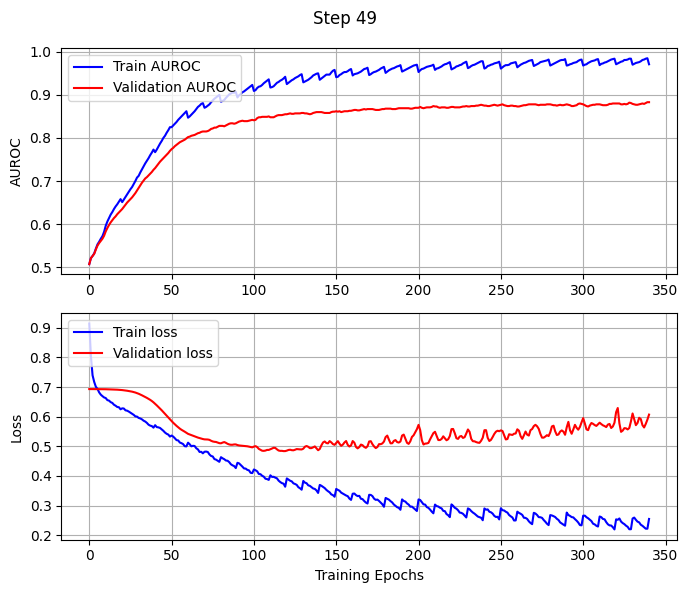

<Figure size 640x480 with 0 Axes>

In [64]:
# params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[1].to_dict()
# experiment_id = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[1].name
# params["supervision_types"] = [("gene_protein","gda","disease")]

# negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
# results = {}
# metrics,models,curves = run_multiple_seeds(data,params,negative_sampler)

# print(metrics)
# plot_training_stats_sep(f"Step {experiment_id}",*curves[0],save_to+f"{experiment_id}.png")

Poner a hacer esto cuando dejo la compu

Model 0 of 5
(0.889, 0.0)


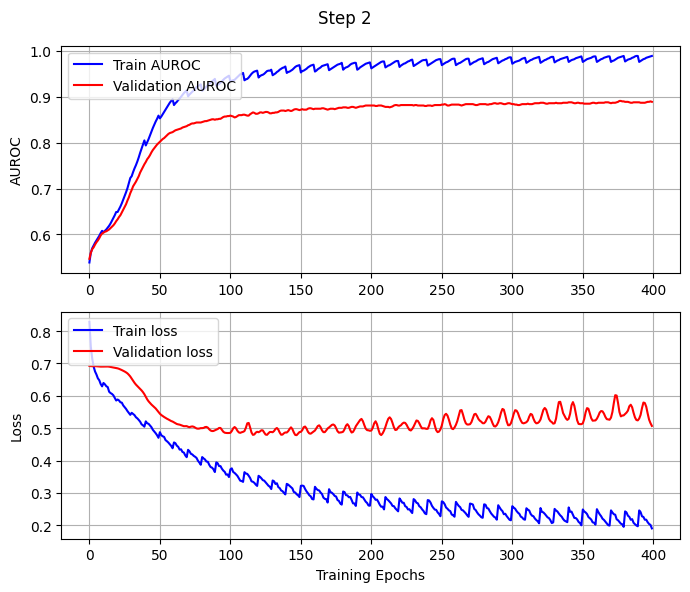

Model 1 of 5
Early stopping
(0.885, 0.0)


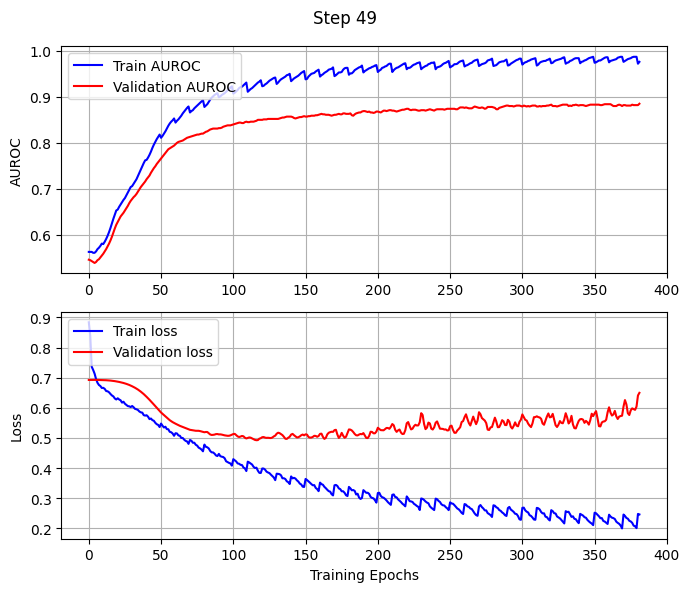

Model 2 of 5
Early stopping
(0.888, 0.0)


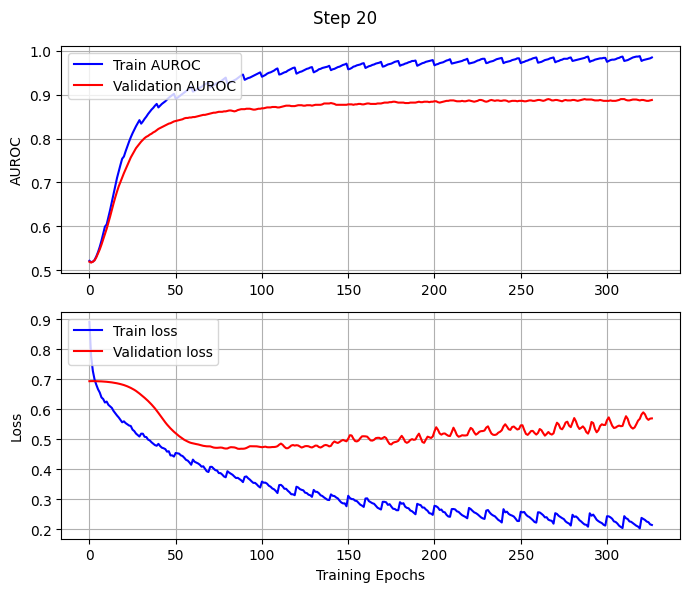

Model 3 of 5
Early stopping
(0.883, 0.0)


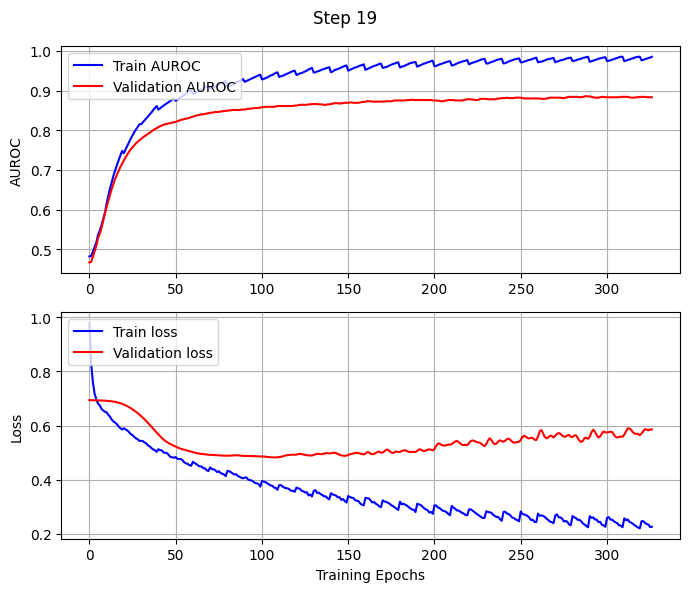

Model 4 of 5
(0.882, 0.0)


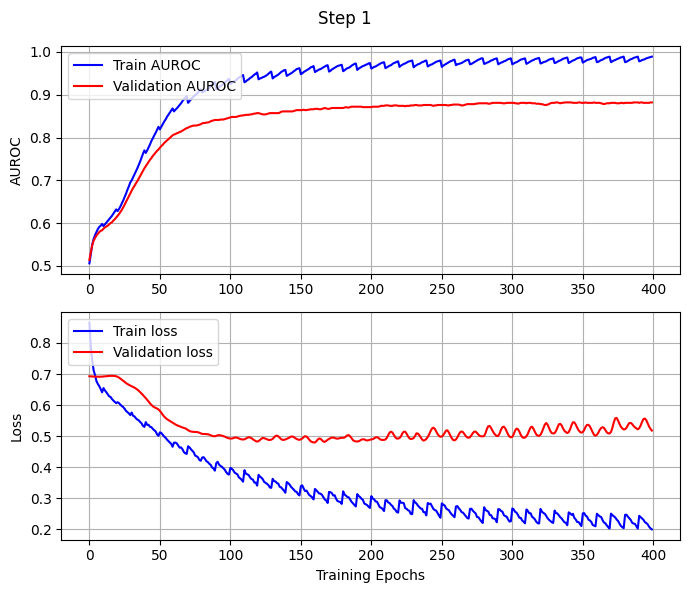

Model +1
(0.8812000000000001, 0.0033704599092705466)


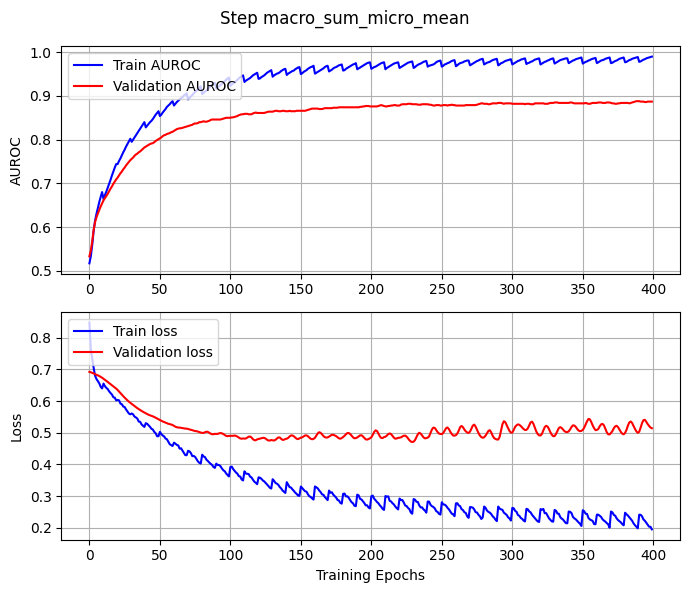

In [16]:
# for i in range(5):
#     print(f"Model {i} of 5")
#     params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[i].to_dict()
#     experiment_id = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[i].name
#     params["supervision_types"] = [("gene_protein","gda","disease")]

#     negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
#     results = {}
#     metrics,models,curves = run_multiple_seeds([data[0]],params,negative_sampler)

#     print(metrics)
#     plot_training_stats_sep(f"Step {experiment_id}",*curves[0],save_to+f"{experiment_id}.png")

# print("Model +1")
# best_params = params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[i].to_dict()
# params = best_params|{"macro_aggregation":"sum","micro_aggregation":"mean"}
# experiment_id = "macro_sum_micro_mean"
# params["supervision_types"] = [("gene_protein","gda","disease")]

# negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
# results = {}
# metrics,models,curves = run_multiple_seeds(data,params,negative_sampler)

# print(metrics)
# plot_training_stats_sep(f"Step {experiment_id}",*curves[0],save_to+f"{experiment_id}.png")
# np.savetxt(save_to+experiment_id+".txt",metrics)

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch_sparse/tensor.py:511: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())


Early stopping
Early stopping
(0.758, 0.14618755076955084)


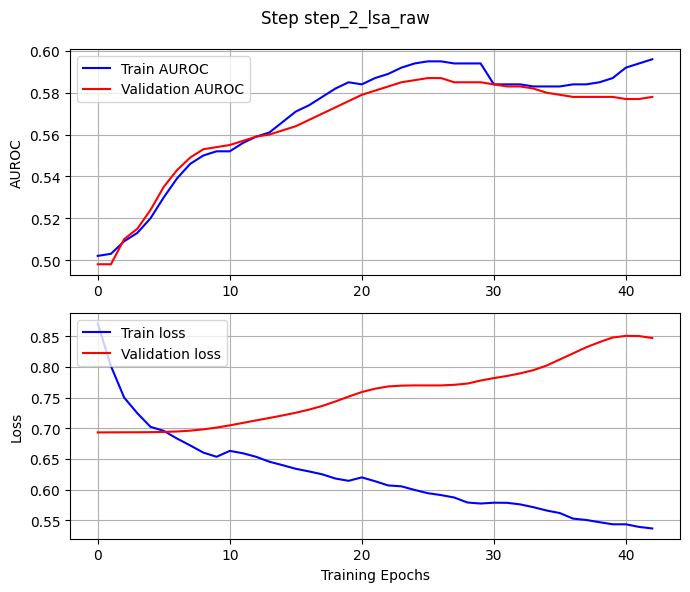

In [8]:
best_params = params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[0].to_dict()
params = best_params|{"feature_type":"lsa"}
experiment_id = "step_2_lsa_raw"
params["supervision_types"] = [("gene_protein","gda","disease")]

negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}
metrics,models,curves = run_multiple_seeds(data,params,negative_sampler)

print(metrics)
plot_training_stats_sep(f"Step {experiment_id}",*curves[0],save_to+f"{experiment_id}.png")
np.savetxt(save_to+experiment_id+".txt",metrics)

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packag

(0.8682000000000001, 0.0031874754901018484)


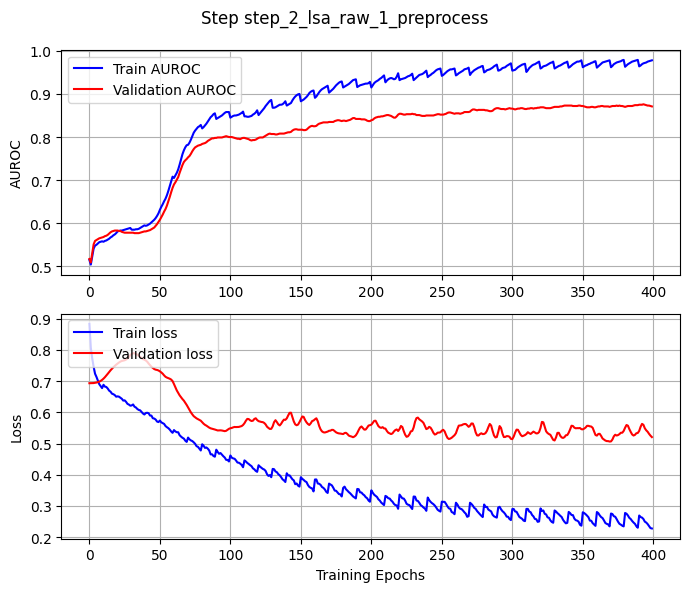

In [9]:
best_params = params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[0].to_dict()
params = best_params|{"feature_type":"lsa","pre_process_layers":1}
experiment_id = "step_2_lsa_raw_1_preprocess"
params["supervision_types"] = [("gene_protein","gda","disease")]

negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}
metrics,models,curves = run_multiple_seeds(data,params,negative_sampler)

print(metrics)
plot_training_stats_sep(f"Step {experiment_id}",*curves[0],save_to+f"{experiment_id}.png")
np.savetxt(save_to+experiment_id+".txt",metrics)

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch_sparse/tensor.py:511: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy 

(0.8657999999999999, 0.0024819347291981735)


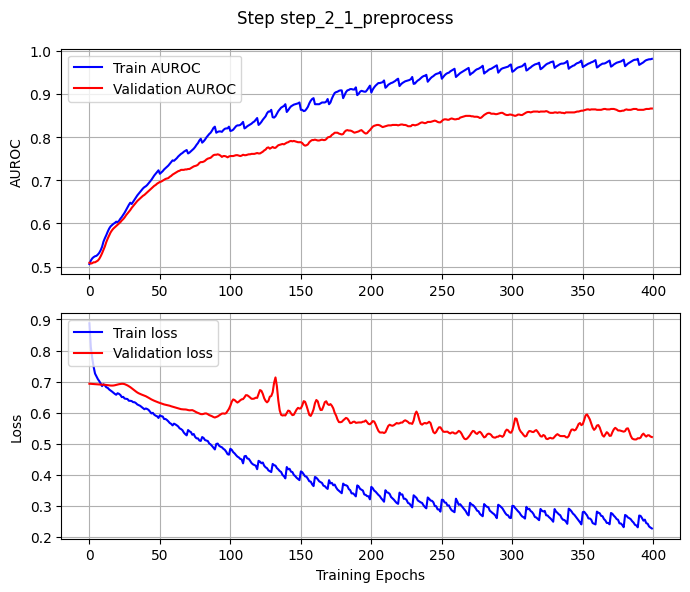

In [6]:
best_params = params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[0].to_dict()
params = best_params|{"pre_process_layers":1}
experiment_id = "step_2_1_preprocess"
params["supervision_types"] = [("gene_protein","gda","disease")]

negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}
metrics,models,curves = run_multiple_seeds(data,params,negative_sampler)

print(metrics)
plot_training_stats_sep(f"Step {experiment_id}",*curves[0],save_to+f"{experiment_id}.png")
np.savetxt(save_to+experiment_id+".txt",metrics)